- **ipylernel** -> It provides a IPython kernel for Jupyter notebook.
- **python-dotenv** -> It reads key-value pairs from a .env file and can set then as an environment variables.
- **pypdf** -> need to install when using PyPDFLoader

Reference: https://python.langchain.com/docs/tutorials/rag/
## Retrieval Augmented Generation (RAG)
RAG is a technique for augmenting LLM knowledge with additional data. The process of bringing and inserting appropriate information into the model prompt is known as RAG. We can use this with both **unstructured and structured** data like SQL data.

A typical RAG application has two main components:
- **Indexing:** a pipeline for ingesting data from a source and indexing it. This usually happens offline.
    - **Load** means Data Ingestion
    - **Split** means Data Transformation-dividing into chunks
    - **Store** means VectorStore DB- embed and then store

    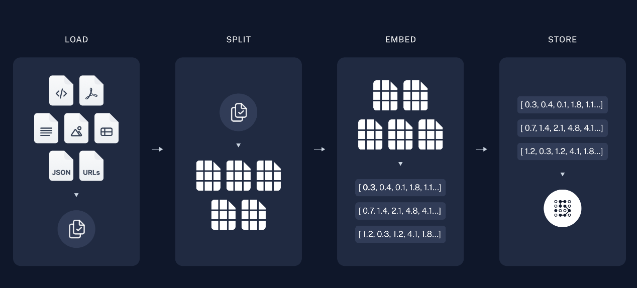
- **Retrieval and Generation:** the actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.
    - **Retrieve** means Retrieval chain, which is an inteface responsible for querying vector store db and get context info
    - **Generate** means pass the prompt and context info to get the final response

    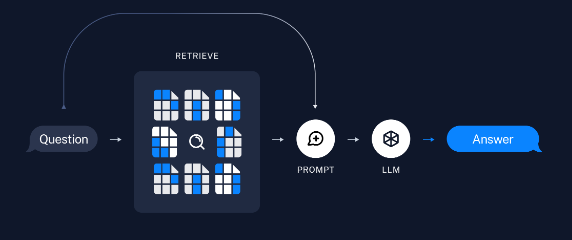

Reference: https://python.langchain.com/docs/integrations/document_loaders/

### Data Ingestion - DocumentLoaders
DocumentLoaders load data into the standard LangChain Document format. Each DocumentLoader has its **own specific parameters**, but they can all be invoked in the same way with the **.load()** method. (**.load_and_split()**)
- **TextLoader:** to load any **.txt** files
- **PyPDFLoader:** to load any **.pdf** files
- **WebBaseLoader:** to load any **HTML web page** using url path
- **ArxivLoader:** to load any **research paper completely** using that paper code
- **WikipediaLoader:** to load any **wikipedia content completely** based on any topic

In [ ]:
# TextLoader - loading a speech.txt file
from langchain_community.document_loaders import TextLoader

# providing the filepath in the loader
loader=TextLoader('files/speech.txt')

# invoking the loader by calling .load() method
txt_doc=loader.load()
txt_doc

In [ ]:
# PyPDFLoader - loading a summary.pdf file
from langchain_community.document_loaders import PyPDFLoader

# providing the filepath in the loader
loader=PyPDFLoader('files/summary.pdf')

# invoking the loader by calling .load() method
pdf_doc=loader.load()
print(pdf_doc)
print(type(pdf_doc))

# If we're loading a large number of Documents, we can lazily load our Documents one at a time to minimize our memory footprint
docs = []
for doc in loader.lazy_load():
    docs.append(doc)

    if len(docs) >= 10:
        # do some paged operation, e.g.
        # index.upsert(doc)
        docs = []
len(docs)

In [ ]:
# WebBaseLoader - loading a html web page 
from langchain_community.document_loaders import WebBaseLoader
import bs4

# this will load the entire url content
loader=WebBaseLoader('https://en.wikipedia.org/wiki/Generative_artificial_intelligence')
web_doc=loader.load()
print(web_doc)

# if we want to load only specific content like on the basis of classes used in html page
loaderSpecific=WebBaseLoader('https://en.wikipedia.org/wiki/Generative_artificial_intelligence', 
                             bs_kwargs=dict(parse_only=bs4.SoupStrainer(
                                 class_=("mw-page-title-main","vector-body-before-content")
                             )))
specific_class_loader=loaderSpecific.load()
specific_class_loader

In [ ]:
# ArxivLoader - to load complete research paper using paper code
from langchain_community.document_loaders import ArxivLoader

loader=ArxivLoader(
    query='2411.09391',
    load_max_docs=2,
    # doc_content_chars_max=1000,
    # load_all_available_meta=False,
    )
arxiv_doc=loader.load()
arxiv_doc

arxiv_summary=loader.get_summaries_as_docs()
arxiv_summary

In [ ]:
# WikipediaLoader - just provide any topic which you want to search on wikipedia 
from langchain_community.document_loaders import WikipediaLoader

loader=WikipediaLoader(
    query='gen ai',
    load_max_docs=2,
    lang='en',
    load_all_available_meta=False,
    doc_content_chars_max=100,
    )
wiki_doc=loader.load()
wiki_doc

Reference: https://python.langchain.com/docs/concepts/text_splitters/

### Data Transformation - langchain_text_splitters

It involves breaking down large texts into smaller, manageable chunks. This process offers several benefits, such as ensuring consistent processing of varying document lengths, overcoming input size limitations of models, and improvind the quality of text representations used in retrieval systems. There are several strategies for splitting documents, each with its own advantages.

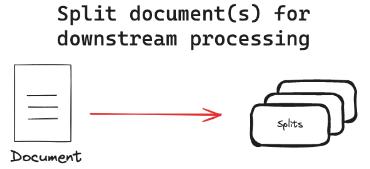

**Different Approches for text splitting**
- **CharacterTextSplitter:** Length-based: each chunk doesn't exceed a specified size limit
    - **Token-based:** split text based on the number of tokens (depends on what tokenzier LLM model used to convert text into token -> OpenAI's tiktoken)
    - **Character-based:** split text based on the number of characters (Each letter, symbol, punctuation mark, or space is 1 character)
- **RecursiveCharacterTextSplitter:** attempts to keep larger units(e.g., paragraph) intact. If a unit exceeds the chunk size.it moves to next level(e.g., sentences). This process continue down to the word level if necessary.
- **HTMLHeaderTextSplitter:** split texts at the HTML element level and adds metadata for each header "relevant" to any given chunk
- **RecursiveJsonSplitter:** split json data

NOTE: At last we want that the splitted chunks to be document format so there are some methods:
- **.split_text():** To obtain the string content directly, use .split_text()
- **.create_documents():** if the type of chunks is not doc then use this method as it will split the text and then convert it in document format. To create LangChain Document objects (e.g., for use in downstream tasks), use .create_documents()
- **.split_documents():** if the type of chunks is doc already then use this method to simply split it. 
- **.split_json():** split the json data into chunks



### Chunking Strategies
The core idea is to break down large bodies of text into smaller, more manageable segments (chunks) to address limitations of LLMs (like context window limits), improve retrieval accuracy, and reduce computational costs. The effectiveness of a chunking strategy depends heavily on the specific use case, the nature of the data, and the LLM/embedding model being used. There isn't a single "best" strategy; often, a combination or experimentation is required.

The primary goal of chunking in RAG is to create segaments that are:
- **Small enough** to fit within the token limit of LLM
- **Large enough** to retain sufficient context and semantic meaning
- **Coherent** so that each chunk represents a complete idea or logical unit

#### Key considerations in chunking
- **Chunk Size:** max length of each chunk
- **Chunk Overlap:** the number of characters or tokens shared between consecutive chunks. overlap helps preserve context that might otherwise be lost at chunk boundaries
- **Separators:** the character or patterns used to identify where text can be split ("\n\n" -> paragraph, "\n" -> sentences, " " -> words)

#### Types of Chunking Strategies
1. Fixed-Size Chunking (Length-based): CharacterTextSplitter, TokenTextSplitter
2. Recursive Chunking: RecursiveCharacterTextSplitter, RecursiveJsonSplitter
3. Document-Specific Chunking: MarkdownTextSplitter, HTMLHeaderTextSplitter, PythonCodeTextSplitter
4. Semantic Chunking: SemanticChunker
5. Small2Big Chunking: ParentDocumentRetrieval
6. Agentic Chunking
7. Hybrid Chunking
8. Dynamic Chunking

NOTES: 
- **Sliding Window Chunking** means chunking technique having chunk_overlap specified, chunk_overlap!=0
- Fixed-size chunking is considered as not context-aware while rest all are considered as **context-aware chunking techniques**

#### RecursiveCharacterTextSplitter

This text splitter is the recommended one for generic text. It is parameterized by a list of characters. It tries to split on them in order until the chunks are small enough. The default list is ["\n\n", "\n", " ", ""]. This has the effect of trying to keep all paragraphs ( and then sentences, and then words) together as long as possible, as those would generically seem to be the strongest semantically related pieces of text.
- How the text is split: by list of characters
- How the chunk size is measured: by number of characters

In [ ]:
# RecursiveCharacterTextSplitter - How to recursively split text by characters
from langchain_text_splitters import RecursiveCharacterTextSplitter

# creating the instance of text splitter
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=20
    )

# using .split_ducments()
split_texts=text_splitter.split_documents(txt_doc)
print(split_texts)

# using .create_documents()
speech=''
with open('files/speech.txt') as f:
    speech=f.read()
texts=text_splitter.create_documents([speech])
print(texts)

#### CharacterTextSplitter
This is the simplest method. This splits based on a given character sequence, which default to "\n\n". Chunk length is measured by number of characters.
- How the text is split: by single character separator
- How the chunk size is measured: by number of characters

In [ ]:
# Charactertextsplitter
from langchain_text_splitters import CharacterTextSplitter

char_splitter=CharacterTextSplitter(
    separator='\n\n',
    chunk_size=100,
    chunk_overlap=20
)
texts=char_splitter.split_documents(txt_doc)
print(texts)

# NOTE: Created a chunk of size 382, which is longer than the specified 100
# we got this as within 100 size it will not able to find the separator 

#### HTMLHeaderTextSplitter
HTMLHeaderTextSplitter is a "structure-aware" chunker that splits text at the HTML element level and adds metadata for each header "relevant" to any given chunk.It can be used with other text splitters as part of a chunking pipeline. It can return chunks element by element or combine element with the same metadata, with the objectives of:
- keeping related text grouped (more or less) semantically and 
- preserving context-rich information encoded in document structures

In [ ]:
# HTMLHeaderTextSplitter
from langchain_text_splitters import HTMLHeaderTextSplitter

html_string="""
<!DOCTYPE html>
<html>
<body>

<h1>My First Heading</h1>
<h2>My First Heading</h2>
<h3>My First Heading</h3>
<p>My first paragraph.</p>

</body>
</html>
"""

html_url="https://www.w3schools.com/html/html_intro.asp"

headers_to_split_on=[
    ('h1','header 1'),
    ('h2','header 2'),
    ('h3','header 3'),
]

html_splitter=HTMLHeaderTextSplitter(headers_to_split_on)
html_split=html_splitter.split_text(html_string)
html_split_url=html_splitter.split_text_from_url(html_url)
print(html_split)
print(html_split_url)

#### RecursiveJsonSplitter
This json splitter splits json data while allowing control over chunk sizes. It traverses json data depth first and builds smaller json chunks. It attempts to keep nested json objects whole but will split them if needed to keep chunks between a min_chunk_size and the max_chunk_size.

If the value is not a nested json, but rather a very large string, the string will not be split. If you need a hard cap o the chunk size consider composing this with a Recursive text splitter on those chunks. There is an optional pre-processing step to split lists, by first converting them to json (dict) and then splitting them as such.
- How the text is split: json value
- How the chunk size is measured: by number of characters

In [ ]:
# loading json data from api
import json
import requests

json_data=requests.get('https://api.smith.langchain.com/openapi.json').json()
print(json_data)

In [ ]:
# RecursiveJsonSplitter
from langchain_text_splitters import RecursiveJsonSplitter

json_splitter=RecursiveJsonSplitter(max_chunk_size=300)

# split in json format
json_txt=json_splitter.split_json(json_data)
for json in json_txt[:3]:
    print(json)

# split in json doc format
json_doc=json_splitter.create_documents(texts=[json_data])
for json in json_doc[:3]:
    print(json)

# split in json string format
json_str=json_splitter.split_text(json_data)
for json in json_str[:3]:
    print(json)

#### Semantic Chunking
https://python.langchain.com/docs/how_to/semantic-chunker/

This chunking method aims to extract semantic meaning from embeddings and then assess the semantic relationship between these sentences/embeddings. The core idea is to keep together sentence that are semantic similar. This adaptively picks the breakpoint in-between sentences using embedding similarity.

- buffer_size: configurable parameter that decides the initial window for chunks
- breakpoint_percentile_threshold: The threshold value to decide where to split the chunk
- embed_mode: the embedding model used.

Example: "The cat sat on the mat. It was a fluffy cat. The dog barked loudly. The dog chased the ball. The sun set beautifully. The sky turned orange and purple."
- Similarity (S1, S2) might be high (both about a cat).
- Similarity (S2, S3) might be low (cat to dog). This is a breakpoint.
- Similarity (S3, S4) might be high (both about a dog).
- Similarity (S4, S5) might be low (dog to sunset). This is another breakpoint.
- Similarity (S5, S6) might be high (both about sunset/sky).

This would lead to chunks like:
- Chunk 1: "The cat sat on the mat. It was a fluffy cat."
- Chunk 2: "The dog barked loudly. The dog chased the ball."
- Chunk 3: "The sun set beautifully. The sky turned orange and purple."

In [ ]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()
splitter = SemanticChunker(embeddings)
text = "Galaxies form part of the universe. Black holes are regions of space-time."
chunks = splitter.split_text(text)
print(chunks)

### Small2Big Chunking
- A powerful two-layered approach where we create two sets of chunks "Small (specific chunks might be individual sentences or very small paragraph)" and "Large (parent chunks like original document or sections that the small chunks came from)" and then creating embeddings of all the chunks. 
- During retrieval, search is performed against small chunks to find a precise match and the context passed to LLM for generation is the corresponding large parent chunk
- Imagine searching a library's detailed index cards (small chunks) to find the exact concept you need, but then checking out the entire book (parent chunk) to get the full context.

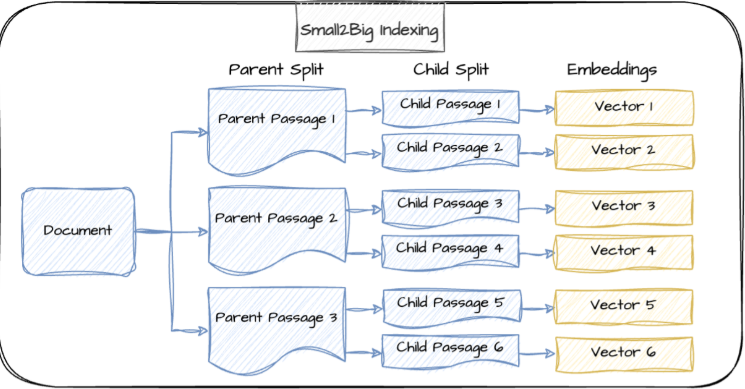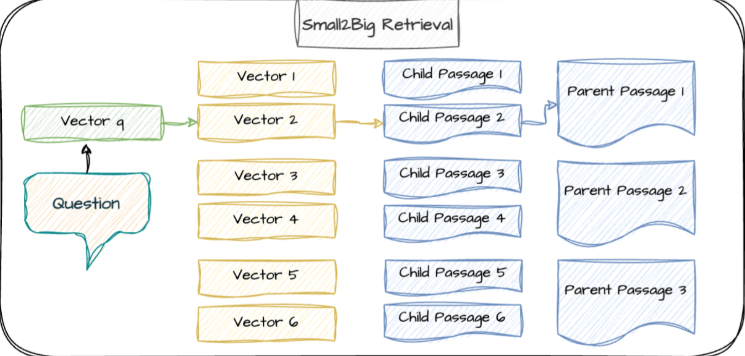

In [ ]:
# text splitter for the parent documents - the large chunks
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=2000)

# text splitter for the child documents - the small chunks
child_splitter = RecursiveCharacterTextSplitter(chunk_size=300)

# the vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name='split_parents', embedding_function=embedding_model)

# the storage layer for the parent documents
store = InMemoryStore()

small_2_big_chunk_retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
    search_kwargs={"k":1}
)

# add data to the retriever
small_2_big_chunk_retriever.add_documents(data)

# setup chain
chain = setup_chain(small_2_big_chunk_retriever)

#### Agentic Chunking
Use LLM to determine the chunk size based on the context. Uses LLMs to dynamically split text based on semantic meaning and contextual flow. Traditional chunking methods (fixed-size, recursive, semantic) rely on pre-defined rules, patterns, or numerical similarity thresholds. The goal is to create chunks that are not just semantically similar, but also optimally useful for a downstream task like Retrieval Augmented Generation (RAG). Agentic chunking flips this by leveraging the LLM's ability to:
- Understand Meaning: Grasp topic shifts(kab topic change hua), identify key arguments, and recognize the start/end of meaningful paragraph.
- Follow Instructions: we provide a prompt to llm instructing how to chunk.
- Synthesize & Summarize: also ask llm to summarize the chunk and extract the theme of the particular chunk, if the particular chunk is having more than one theme then chunking is not done properly we might need to re-prompt based on usecase.

#### Hybrid Chunking
Hybrid chunking is an advanced text splitting strategy that combines multiple chunking techniques to create more semantically coherent and practically sized text segments (chunks). 

**Why is Hybrid Chunking Needed**
- fixed-size chunking is simple, but cut sentences and paragraph mid-way, leading to context loss and incoherent chunks
- sentence-level chunking keeps complete ideas but can result in too many small chunks increasing computational load and losing broader idea or context
- paragraph-level chunking maintains more context but lead to uneven chunk size  and may increase token limit
- semantic chunking is good but can be computationally intensive complex to implement 

**How Hybrid chunking works**
- **Fixed-size with Semantic Adjustment:** first perform fixed size chunking and then using rule based engine, identify the chunks which are not correct(mid-way cut, topic or meaning shift, poor retrieval results and so on based on usecase)mark them flag and apply the sematic chunking on those particular chunks
- **Hierarchical Chunking with Granularity Levels:** It will create chunks at different levels like large chunks(entire section or topics for broad context), medium chunks(paragraph or sub-sections for more detailed information), small chunks(sentences or key phrases for fine-grained retrieval) and during retrieval the system can dynamically choose which granularity level to use based on the query's complexity
- **Context-Aware chunking with Specific Rules:** For structured data like text, tables, images, we want to keeps them intacted so will need to write the specific rule based engine. This ensures that different modalities or structured data within a document are handled to maximize their retrievability and usefulness
- **LLM-Assisted Chunking (IBM's approach):** A document might be initially split into sentences and then an LLM is used to group the similar chunks and create new chunk when topic shifts. The LLM can also extract meaningful metadata(title, id, summary) for each chunk

#### Dynamic Chunking
Unlike static or fixed-size chunking, where documents are cut into predetermined lengths, dynamic chunking adapts the chunk size and boundaries based on the content, structure, and semantic meaning of the text itself. The core idea is to create chunks that are not just within the token limit but also have semantic meaning.

**Why is Dynamic chunking Needed?**
- Context Fragmentation: A sentence might be split across two chunks losing the full meaning
- Irrelevant Information: A chunk having partial info and info that are nor related
- Suboptimal chunk size: A fixed size might be too small for some context or too large for others

**How Dynamic Chunking Works**
- Semantic Similarity-based Chunking: Embed each sentences or small segments and calculate the cosine similarity between the embeddings of consecutive sentences and where the score drops the threshold start creating new chunk 
- Context-Aware/Structural Chunking: It parses the document to identify structural elements like headings, html, pdf layout and then apply semnatic chunking on sub-sections based on the usecase
- LLM-Assisted Chunking: An LLM can be prompted to analyze a text segment, topic shifts, summarize key theme or idea to determine if they should be grouped, suggest chunk size and chunk overlap
- Query-Adaptive/Retrieval-Time Chunking: Instead of pre-chunking the entire document, dynamically adjust the chunking or retrieval strategy at the time of the query. 
    - Hierarchical Indexing: The document might be indexed at multiple granularities (e.g., document-level summaries, section summaries, paragraph chunks, sentence chunks).
    - Dynammic Retrieval: When a query comes in, first retrieves higher-level chunks(section summaries) to get the broad idea and then based on that it can go deeper level chunks(paragraph/sentences summaries)
    - This is less about "chunking" as a pre-processing step and more about dynamic retrieval strategies that leverage multi-level data representation.

### Embedding: 
Reference: https://python.langchain.com/docs/concepts/embedding_models/

#### Types of Embeddings
- Text Embeddings
    1. Word Embeddings
        - Traditional Word Embeddings/Fequency-based: One-hot Encoding, Bag-of-Words
        - Static Word Embeddings/Prediction-based: Word2Vec, GloVe(Global Vectors for Word Represenation), FastText
        - Contextualized Word Embeddings: ELMo(embeddings from Language Models), BERT(Bidirectional Encoder Representation from Transformers), GPT(Generative Pre-trained Transformers)-x
    2. Sentence Embeddings: Sentence-BERT(SBERT), USE(Universal Sentence Encoder), Simple Aggregation of word embeddings
    3. Paragraph/Document Embeddings: Doc2Vec, Simple Aggrehation of word/sentence embeddings
- Image Embeddings: ViT(Vision Transformers), pre-trained CNN models(resNet, VGG, Inception, EfficientNet) using Pytorch or Tensorflow
- Graph Embeddings
    1. Node Embeddings: DeepWalk, Node2Vec, LINE(Large-scale Information Network Embedding), GCNs(Graph Convolutional Networks), GraphSAGE(SAmple and aggreGatE), GATs(Graph Attention Networks)
    2. Graph Embeddings (whole graph): Aggregation of Node Embeddings, Graph Kernels, Graph2Vec
    3. Edge Embeddings -> Knowledge Graph Embeddings: TransE, RESCAL, DistMult, ComplEx
- Multimodal Embeddings: CLIP(Contrastive Language-Image Pre-training) by OpenAI, ALIGN(A Large-scale ImaGe-NaturaL language grounding) by Google
- Transformer-based Embeddings: means for any type of embeddings using transformer models like BERT, GPT

#### Word Embeddings
Numerical representations (vectors) of words that capture their semantic meaning and relationship. Word embedding models learn to represent words as dense vectors by analyzing vast amounts of text data. The training process ensures that words with similar meanings or usages are positioned closer to each other in the vector space. For example, the vectors for "cat" and "kitten" would be closer than "cat" and "car."

1. **Static Word Embeddings:**
These embeddings assign a fixed vector to each word, regardless of the context in which it appears. While simple and computationally efficient, they struggle with **polysemy** (words having multiple meanings, e.g., "bank" as a financial institution vs. "bank" as the side of a river). Poorly handles out-of-vocabulary (OOV) words unless using sub-word units.

2. **Contextualized Word Embeddings:**
These embeddings generate a word's vector representation dynamically based on its specific context within a sentence or document. This addresses the polysemy issue inherent in static embeddings, as the same word can have different vectors depending on its surrounding words.

#### Sentence Embeddings
Numerical vector representations of entire sentences that capture their semantic meaning and the holistic meaning of the complete sentence. Instead of representing individual words, these embeddings encode the meaning of a whole sequence of words into a single, dense vector. The core idea is that sentences with similar meanings will have vectors that are close to each other in the multi-dimensional embedding space.

**WHY?** While word embeddings are powerful, simply averaging or concatenating the embeddings of individual words in a sentence often fails to capture the full semantic meaning, especially due to:
- Word Order: The order of words significantly impacts meaning ("The dog bit the man" vs. "The man bit the dog"). Simple averaging loses this.
- Syntactic Structure: Grammatical relationships influence meaning.
- Compositionality: The meaning of a sentence is often more than just the sum of its individual words.
- Polysemy in context: While contextualized word embeddings help, a single sentence embedding needs to encompass the overall context.

In [ ]:
# model name: USE
import tensorflow_hub as hub
import numpy as np
from scipy.spatial.distance import cosine # For similarity calculation

# Load the Universal Sentence Encoder model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

sentences = [
    "The quick brown fox jumps over the lazy dog.",
    "A fast, ginger canine leaps above the sluggish mutt.",
    "The cat sat on the mat."
]

# Generate embeddings
sentence_embeddings = embed(sentences)
print("USE Sentence embeddings shape:", sentence_embeddings.shape) # (num_sentences, embedding_dim)

# Calculate cosine similarity
similarity_1_2 = 1 - cosine(sentence_embeddings[0], sentence_embeddings[1])
similarity_1_3 = 1 - cosine(sentence_embeddings[0], sentence_embeddings[2])

print(f"Similarity between '{sentences[0]}' and '{sentences[1]}': {similarity_1_2:.4f}") # High
print(f"Similarity between '{sentences[0]}' and '{sentences[2]}': {similarity_1_3:.4f}") # Low

In [ ]:
# model name: Sentence-BERT
from sentence_transformers import SentenceTransformer, util

# Load a pre-trained SBERT model (e.g., 'all-MiniLM-L6-v2' is a good lightweight option)
model = SentenceTransformer('all-MiniLM-L6-v2')

sentences = [
    "The cat is on the mat.",
    "A feline is sitting on a rug.",
    "Dogs love to play fetch."
]

# Generate embeddings
embeddings = model.encode(sentences, convert_to_tensor=True)
print("SBERT Embeddings shape:", embeddings.shape) # (num_sentences, embedding_dim)

# Calculate cosine similarity between sentences
cosine_score_1_2 = util.cos_sim(embeddings[0], embeddings[1])
cosine_score_1_3 = util.cos_sim(embeddings[0], embeddings[2])

print(f"Similarity between '{sentences[0]}' and '{sentences[1]}': {cosine_score_1_2.item():.4f}") # High
print(f"Similarity between '{sentences[0]}' and '{sentences[2]}': {cosine_score_1_3.item():.4f}") # Low

#### Paragraph/Document Embeddings
Numerical vector representations of entire paragraphs, documents, or even larger bodies of text, designed to capture their holistic semantic meaning. Similar to how word embeddings represent individual words and sentence embeddings represent sentences, document embeddings aim to encapsulate the overarching topic, context, and latent meaning of a complete text. Provides a concise, fixed-size representation that summarizes the entire text, facilitating tasks that operate at a document level.

**WHY?** While word and sentence embeddings are powerful, they have limitations when dealing with longer texts:
- Loss of Macro-Levelcontext: Averaging sentence embeddings might lose the broader narrative or thematic flow of a document.
- Computational cost of Long texts: Processing very long documents sentence by sentence can be inefficient.
- Topic Modeling: Document embeddings are more suitable for tasks requiring an understanding of the document's main subject or intent.

#### Image Embeddings
Numerical vector representations of images that capture their visual features and semantic content. They allow computers to understand, compare, and process images by translating them into a language that machine learning models can readily interpret. Similar images will have embeddings that are close to each other in a multi-dimensional vector space.

The common and recommended workflow involves loading the image using an image processing library (like PIL/Pillow or OpenCV) and then applying transformations to that image object. These transformations prepare the image data in a numerical tensor format suitable for the deep learning model. The deep learning model is indeed the component that takes the preprocessed numerical tensor (representing your image) and converts it into the final numerical embedding.

1. Choose a Pre-trained Model: Select a suitable CNN or ViT.
2. Load the Model and Preprocessor: Get your model and its associated transformation pipeline ready.
3. Prepare Your Image: Load your image file and apply the necessary resizing, cropping, normalization, and tensor conversion.
4. Modify the Model (Optional, but Recommended): Remove the classification head to get the feature extractor.
5. Generate the Embedding: Pass the preprocessed image tensor through the modified model.
6. Use the Embedding: Apply the resulting vector for your specific task (similarity, clustering, etc.).

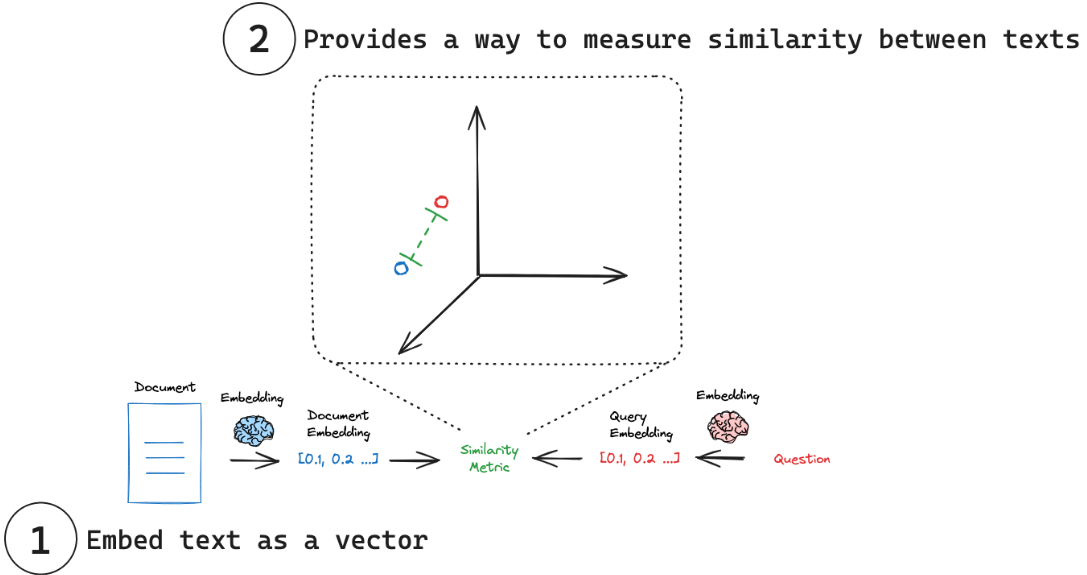

Embedding models transform human language into a format that machines can understand and compare with speed and accuracy. These models take text as input and produce a fixed-length array of numbers, a numerical fingerprint of the text's semantic meaning. Embeddings allow search system to find relevant documents not just based on keyword matches, but on semantic understanding.

**Embedding Frameworks**
- OpenAIEmbeddings: text-embedding-ada-002, text-embedding-3-large
- OllamaEmbeddings: mxbai-embed-large, nomic-embed-text
- HuggingFaceEmbeddings: all-MiniLM-L6-v2, mpnet-base-v2

**functions used:**
- use **.embed_query()** when passing single string
- use **.embed_documents()** when pass content of type doc or else pass list of strings

Reference: https://platform.openai.com/docs/guides/embeddings#embedding-models

#### OpenAIEmbeddings
There are different model we can use to create embeddings using OpenAI

In [ ]:
# loading all content from .env file 
import os
from dotenv import load_dotenv

# this will load all the content from the .env file to our coding environment
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [ ]:
from langchain_openai import OpenAIEmbeddings

# we can use any avaiable model in the docs of openai
ai_embeddings=OpenAIEmbeddings(
    model='text-embedding-3-large',
    # dimensions=1024,    # optional
    )
print(ai_embeddings)

text="creating openai embeddings"
query=ai_embeddings.embed_query(text)
print(len(query))

In [ ]:
# creating and storing the embedding in chromadb
from langchain_community.vectorstores import Chroma

# pass the document and embedding technique which you want to use to create the provided doc into vector
# here split_texts is the result of RecursiveCharacterTextSplitter
db=Chroma.from_documents(split_texts,ai_embeddings)
print(db)

In [ ]:
# querying the vector db
query='some question related to embedded document here split_texts'
retrieved_data=db.similarity_search(query)
print(retrieved_data)

Reference: https://ollama.com/search?c=embedding

#### OllamaEmbeddings
Ollama supports embedding models, making it possible to build retrieval augmented generation (RAG) application that combine text prompts with exsiting documents or other data. 
This is an open-source which provide llm models and embedding technique. To use this, we need to download "Ollama" from 'https://ollama.com' in our local device

So to use different models, we first need to install them particularly which we want to use using commands given in ollama github like if i want to use 'Llama 3' model then i need to run the command in command prompt 'ollama run llama3'

In [ ]:
from langchain_community.embeddings import OllamaEmbeddings

# embedding created with mentioned model
o_embeddings=(
    OllamaEmbeddings(model='llama3')    # by default ir uses llama2
)
print(o_embeddings)

# use .embed_query() when passing single string
text="creating embedding using ollama model llama3"
result=o_embeddings.embed_query(text)
print(result)
print(len(result))

# use .embed_documents() when pass content of type doc or else pass list of strings
docs=['Alpha is 1st greek alphabet', 'Beta is 2nd greek alphabet']
res=o_embeddings.embed_documents(docs)
print(res)
print(len(res[0]))

Reference: https://huggingface.co/models

#### HuggingFaceEmbeddings
HuggingFace sentence-transformers is a Python framework for state-of-the-art sentence, text and image embeddings. One of the embeddings models is used in the HuggingFaceEmbeddings class. We have also added an alias for SentenceTransformerEmbeddings for users who are more fimilar with directly using that package.

In [ ]:
# loading token from .env file
os.environ["HF_TOKEN"]=os.getenv("HF_TOKEN")

In [ ]:
# from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.embeddings import HuggingFaceEmbeddings

model_name = "sentence-transformers/all-MiniLM-L6-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
hf_embeddings=HuggingFaceEmbeddings(
    model_name=model_name,
    # model_kwargs=model_kwargs,
    # encode_kwargs=encode_kwargs
)
print(hf_embeddings)

In [ ]:
# use .embed_query() when passing single string
text="creating embedding using huggingface sentence-transformers"
result=hf_embeddings.embed_query(text)
print(result)
print(len(result))

# use .embed_documents() when pass content of type doc or else pass list of strings
docs=['Alpha is 1st greek alphabet', 'Beta is 2nd greek alphabet']
res=hf_embeddings.embed_documents(docs)
print(res)
print(len(res[0]))

Reference: https://python.langchain.com/docs/concepts/vectorstores/

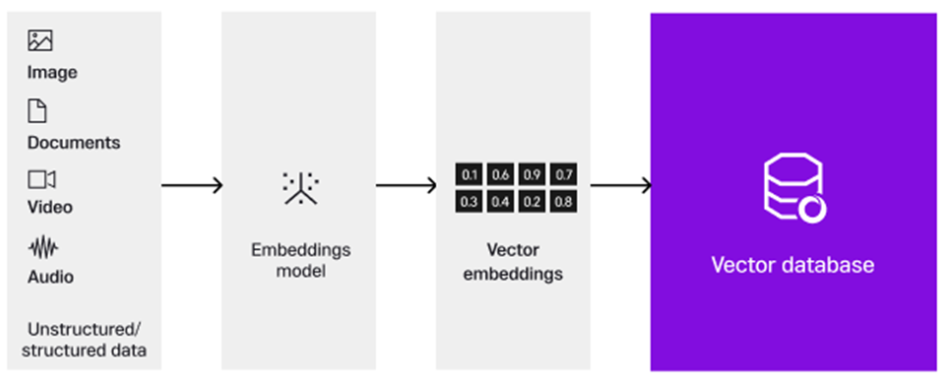

https://nexla.com/ai-infrastructure/vector-databases/#:~:text=Categorization%20based%20on%20data%20type

### VectorStores
Vector stores are specilized data stores that enable indexing and retrieving information based on vector representations. These vectors, called embeddings, capture the semantic meaning of data that has been embedded.

Vectore stores are frequently used to search over unstructured data, such as text, images, and audio, to retrieve relevant information based on semantic similarity rather than exact keyword matches.

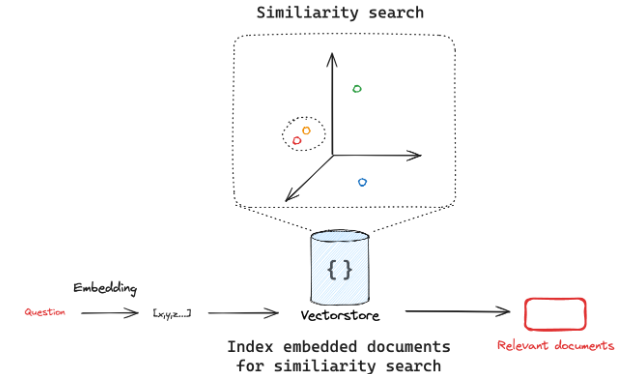

#### Indexing in Vector database
- It is a process of organizing vectors to make finding similar vectors fast and efficient, allowing the vector store to quickly narrow down the search space
- indexing works by transforming a raw collection of vectors into a specialized data structure that allows for rapid lookup of similar vectors. (transforming is internally handled by vector database or vector search library itself)
- without indexing, finding similar vectors reuqires comparing query vector to every single vector in entire dataset
- vector stores like Faiss and ChromaDB internally handle the indexing process. we don't need to manually apply complex indexing algorithms like HNSW or IVF
- Indexing is like organizing your library's books by topic codes (vectors) so you can quickly find similar books without searching every single one.

NOTE: If query includes metadata filters (e.g., find blue running shoes under 100), the vector store first applies these filters to narrow down the vector space it needs to search.It only considers vectors that match the metadata criteria.

**Indexing Techniques**

Approximate Nearest Neighbor (ANN) Algorithms: These are the most common. They don't guarantee finding the absolute closest match but are incredibly fast. 
- **Locality Sensitive Hashing (LSH):** Uses hash functions to group similar items into the same "buckets". The query vector is passed through the same LSH hash function that were used to hash the indexed vectors and then it identify one or more bucket id's for the query vector, now the search is limited to only those vectors which are stored in those bucket id's
- **Hierarchical Navigable Small Worlds (HNSW):** Builds a multi-layered graph where each vector is a nnode. When a query comes in, the search typically starts at a random or predefined entry point on the top-most level. The algorithm compares the query vector to its immediate neighbors and greedily moves to the neighbor that is closest and go deeper layers and repeat this "move closer, then go deeper" process until it reaches the bottom-most layer
- **Inverted File Index (IVF):** Partitions the vector space into n clusters, each with centroids, when a query comes in, it compares all the centroids with query vector to find out the list of most closest centroids, now the search is limited to those vectors only 

**Different ways to store vector**
- FAISS: open-source library for efficient similarity search, high-performance
- Chroma: open-source vector database, simple, lightwieght, local developemnt
- Pinecone: fully managed, cloud-native vector database (SaaS), paid, zero-ops(no need to manage anything), enterprise-ready scale
- Qdrant: open-source, high performance vector database (self-hosted or cloud-managed)
- Deep Lake: 

#### FAISS
Facebook AI Similarity Search (FAISS) is a library for efficient similarity search and clustering of dense vectors. It contains algorithms that search in set of vectors of any size, up to ones that possibly do not fit in RAM. It also contains supporting code for evaluation and parameter tuning.

In [ ]:
from langchain_community.vectorstores import FAISS

db=FAISS.from_documents(split_texts,o_embeddings)
db

In [ ]:
# querying the created vector stores db
query="when the boom of gen ai came"
res_doc=db.similarity_search(query)
print(res_doc)

# will also get l2 score - Manhattan Distance score
res_doc_with_score=db.similarity_search_with_score(query)
print(res_doc_with_score)

# passing query as vector data
query_vector=o_embeddings.embed_query(query)
res_doc_with_vector=db.similarity_search_by_vector(query_vector)
print(res_doc_with_vector)

#### Saving and Loading
Saving the vectorstores in local
- **.save_load('folder_name'):** it will create a folder with provided name inside which two files will be there as 'index.faiss' and 'index.pkl'
loading that saved vectorstores
- **.load_local('folder_name',embeddings,allow_dangerous_deserialization=True)**

In [ ]:
db.save_local('faiss_vectorstores')

In [ ]:
faiss_db=FAISS.load_local('faiss_vectorstores',o_embeddings, allow_dangerous_deserialization=True)

#### Chorma
Chroma is a AI-native open-source vector database focused on developer productivity and happiness. Chroma is licensed under Apache 2.0.

In [ ]:
# chromadb or langchain-chroma is not getting installed so cann't run this part
from langchain_chroma import Chroma

chroma_db=Chroma.from_documents(split_texts,o_embeddings)

# querying chroma db
chroma_doc=chroma_db.similarity_search(query)

# saving vectorstores db in local
chroma_db=Chroma.from_documents(
    documents=split_texts,
    embedding=o_embeddings,
    persist_directory="./chroma_db"
    )

# loading the saved vector store db
chroma_saved=Chroma(
    persist_directory="./chroma_db",
    embedding_function=o_embeddings
)

# retriever 
chroma_retriever=chroma_db.as_retriever()
chroma_retriever.invoke("query question")

Reference: https://python.langchain.com/docs/concepts/retrievers/

### Retrievers
We can also convert the vectorstroes into a Retriever class using **.as_retriever()** method and we can invoke that retriever using **.invoke()** method. LangChain provides a uniform interface for interacting with different types of retrieval systems. The LangChain retriever interface is straightforward:
- Input: A query (string)
- Output: A list of documents (standardized LangChain Document objects)

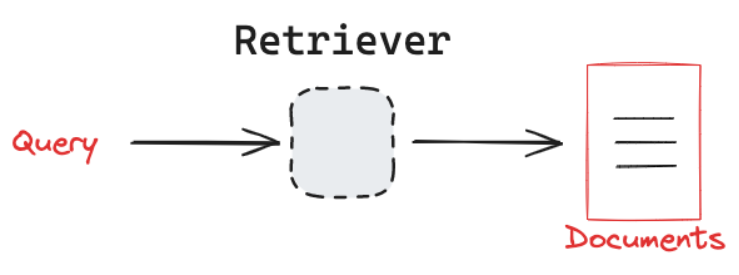

Think of a retriever as a librarian. When you ask the librarian a question, they don't read every book in the library. Instead, they use their knowledge of the library's organization and the content of the books to quickly pull out the most relevant ones. Similarly, a retriever sifts through a "document store" (which could be a database, a collection of files, or a vector store) and identifies the top documents or chunks of information that best match the user's query.

When you call *your_vectorstore.as_retriever()*, you're transforming your raw VectorStore object into a VectorStoreRetriever object.

Our VectorStore itself has methods like *similarity_search()* or *max_marginal_relevance_search()* that do the heavy lifting of finding relevant documents based on vector similarity. The *as_retriever()* method simply packages these search functionalities into the standard Retriever interface, making it interoperable with other LangChain components like Chains, Agents, and RAG pipelines.

*as_retriever()* takes "search_type" and "search_kwargs" parameters

In [ ]:
# this thing is same as the above querying the faiss db using similarity_search()
# but we need to use this retriever as for using different other models
# convert faiss db to retriever
faiss_retriever=db.as_retriever()

# using saved vector store in local
faiss_retriever=faiss_db.as_retriever()
faiss_retriever.invoke(query)